<h1>Exploring proteomics data from TCGA/CPTAC breast cancer samples</h1>

This tutorial offers help on getting started with quantitative mass spectrometry proteomics data on The Cancer Genome Atlas (TCGA) breast cancer samples, provided by the Clinical Proteomic Tumor Analysis Consortium (CPTAC).

The tutorial uses R. I am considering making a Python version as well; give me a shout if you would like that.

As we cannot provide the proteomics data on GitHub, you need to download the data yourself at CPTAC (https://cptac-data-portal.georgetown.edu/cptac/study/disclaimer;jsessionid=38B31734799DB427CA4A140ED80E2C1B?accNum=S015)
The archive/files that you download should end up in a folder called "TCGA_Breast_BI_Proteome_CDAP_Protein_Report.r2". In this notebook, it is assumed that this folder lives one step above the current working directory, at "../TCGA_Breast_BI_Proteome_CDAP_Protein_Report.r2".

These data were obtained using so-called iTraq quantification (https://www.broadinstitute.org/scientific-community/science/platforms/proteomics/itraq). As you will see below, the expression values are given in log ratios for each gene product. We are quantifying the expression of proteins (peptides, to be picky), but in this case the expression values have been mapped to the name of the gene that codes for the protein that we thing we are measuring. This is why I often use the term *gene product* rather than *protein* below. (After all a protein is a gene product. I use the latter expression to remind us that we are using a gene-centric naming system.)  

This tutorial has the following parts. (I may add more parts later, on more sophisticated data integration approaches.)

<h4>Loading and preparing the quantitative mass spectrometry data</h4>
- Pre-processing the data to get a usable data matrix for working with the expression data. 

<h4>Can we find a set of features that predicts PAM50 subtypes?</h4>
- Harmonizing the metadata (breast cancer subtype classifications) with the expression data matrix.
- Performing feature selection with Boruta to find a compact set of protein markers that are predictive of subtype.
- Assessing predictive performance with leave-one-out random forest classification.
- Visualizing the samples with PCA.

<h4>Comparing the proteomics data to RNA-seq data</h4>
- Downloading RNA-seq data and harmonizing it with the proteomics data.
- Looking at correlations between mRNA and protein levels.

But first, let's load the R packages that we need. If you get error messages about some of these not being available, install them using install.packages() or via BioConductor (see below).

In [173]:
library("pheatmap") # if not available, install from CRAN: run install.packages("pheatmap")
library("TCGA2STAT") # if not available, install from BioConductor as shown below: 
                     # source("http://bioconductor.org/biocLite.R")
                     # biocLite("TCGA2STAT")
library("Boruta")    # CRAN
library("readxl")    # CRAN
suppressPackageStartupMessages(library("ggplot2")) # CRAN
suppressPackageStartupMessages(library("randomForest")) # CRAN
suppressPackageStartupMessages(library("STATegRa")) # biocLite()

<h2>Loading and preparing the quantitative mass spectrometry data</h2>

OK. Let's start by importing the data and some information about the samples. Initially, we will need to do some work to get the data on the format we want and to couple it to available metadata. Later, we will go on to try to identify protein markers of breast cancer subtypes and introduce RNA-seq data for the same samples to assess the overall mRNA/protein correlations.

In [174]:
# Replace the below with the appropriate path
fpath <-"../TCGA_Breast_BI_Proteome_CDAP_Protein_Report.r2/Protein_data/CDAP"
# Load the iTraq data
itraq <- read.delim(paste(fpath,"TCGA_Breast_BI_Proteome_CDAP.r2.itraq.tsv",sep="/"),check.names=FALSE,row.names=1)
# We might as well load the metadata as well. These are two different worksheets in the same Excel metadata file.
meta <- read_excel(paste(fpath,"CPTAC_TCGA_BreastCancer_select_clinical_data_r1.xlsx",sep="/"),sheet=1,skip=3)
meta2 <- read_excel(paste(fpath,"CPTAC_TCGA_BreastCancer_select_clinical_data_r1.xlsx",sep="/"),sheet=2,skip=5)

What does it look like? Some sanity checking of the data can never hurt.

In [175]:
itraq[1:5, 1:5]

,A2-A0D0-01A Log Ratio,A2-A0D0-01A Unshared Log Ratio,BH-A0HK-01A Log Ratio,BH-A0HK-01A Unshared Log Ratio,C8-A12T-01A Log Ratio
Mean,-1.976083,-1.926687,-1.63251,-1.605291,-0.4193442
Median,-1.879882,-1.826249,-1.508319,-1.475445,-0.3478403
StdDev,1.162422,1.181425,0.871834,0.8836888,0.4219226
A1BG,0.8154106,0.7617778,1.452402,1.419527,0.3256533
A2M,0.7538061,0.7480863,0.954409,0.9259484,0.002934945


And at the right end of the matrix?

In [176]:
N <- ncol(itraq)
itraq[1:5, (N-5):N]

,A2-A0YD-01A Log Ratio,A2-A0YD-01A Unshared Log Ratio,Description,Organism,Chromosome,Locus
Mean,-0.8851729,-0.8641581,,,,
Median,-0.8392843,-0.8247119,,,,
StdDev,0.5539429,0.5659312,,,,
A1BG,1.009284,0.9947119,alpha-1-B glycoprotein,Homo sapiens,19,19q13.4
A2M,0.413809,0.406959,alpha-2-macroglobulin,Homo sapiens,12,12p13.31


For the purposes of this tutorial, we will focus on the "unshared log ratio" columns in the itraq matrix. 

The first 3 rows and last 4 columns are various descriptors, so we will disregard those..



In [177]:
# Select only the part of the matrix that contains log2 ratios for gene products.
itraq.num <- itraq[4:nrow(itraq),1:216]
# Select the "unshared log ratio" columns 
itraq.log <- as.matrix(itraq.num[,seq(2,ncol(itraq.num),by=2)])

It turns out that the resulting matrix contains a lot of undefined (NA) values. Here, we will take the easy way out and just throw out gene products with NAs.

In [178]:
incompl.meas <- which(is.na(itraq.log),arr.ind=TRUE)
incompl.genesymb <- unique(incompl.meas[,1])
itraq.log <- itraq.log[-incompl.genesymb,]

At this point, we almost have a usable set of quantitative protein measurements that we can work with. However, we may note something else:

In [179]:
print(c(nrow(meta2),ncol(itraq.log)))

[1] 105 108


The itraq.log object has more columns than meta2 has rows. Why? After some digging around we find that some samples occur twice (to wit: AO-A12B-01, AO-A12D-01A, and C8-A131-01A). Perhaps these samples were run twice due to some problem with the first run. Maybe one ought to drop the first occurrence of each, but we could substitute the average for each gene product for the two measurements. For now, we will just keep things as they are, making a mental note that three samples are replicated.

<h2>How are PAM50 subtype classifications reflected in the proteomics data?</h2>

There are several classification systems for describing different subtypes of breast tumors. One common system uses five subtypes: "Basal", "Her2-enriched", "Luminal A", "Luminal B", and "Normal-like". Furthermore, there is a commonly used set of genes, called the PAM50 set, that is frequently used to predict a tumor's subtype based on mRNA expression (on microarrays or RNA-seq). In the annotations for the present data set, there are PAM50 calls for each sample, derived from separate mRNA expression data. It might be interesting to try to find out if the PAM50 subtypes are reflected on the protein level, or conversely whether we can use the proteomics data to predict the (mRNA-based) PAM50 subtype.

The PAM50 classification lives in the meta2 object we loaded earlier, in the 'PAM50 mRNA' column. Let's check how many samples there are of each subtype.

In [180]:
head(meta2)
table(meta2$'PAM50 mRNA')

,Complete TCGA ID,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,ellip.h,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
1,TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,⋯,Basal-like,0,-13,3,5,Basal,3,2,2,2
2,TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,⋯,Basal-like,-12,-13,4,4,Basal,4,2,1,1
3,TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,⋯,Basal-like,-12,-13,5,5,Basal,1,2,2,2
4,TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,⋯,Basal-like,-12,-13,5,5,Basal,1,2,2,2
5,TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,⋯,Basal-like,0,-13,5,5,Basal,1,2,2,2
6,TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,⋯,Basal-like,0,-13,5,5,Basal,1,2,2,2



   Basal-like HER2-enriched     Luminal A     Luminal B 
           25            18            29            33 

OK, so the "normal-like" subtype is missing and we only have samples from four defined subtypes. Good to know!



Now we need to somehow connect the sample names from the itraq.log matrix to those in the PAM50 annotation. Note that the sample names in the metadata (meta2) object are on this form:

In [181]:
head(meta2$'Complete TCGA ID')

[1] "TCGA-A2-A0T2" "TCGA-A2-A0CM" "TCGA-BH-A18V" "TCGA-BH-A18Q" "TCGA-BH-A0E0"
[6] "TCGA-A7-A0CE"

... and the sample names from the itraq.log matrix are on the following form:

In [182]:
head(colnames(itraq.log))

[1] "A2-A0D0-01A Unshared Log Ratio" "BH-A0HK-01A Unshared Log Ratio"
[3] "C8-A12T-01A Unshared Log Ratio" "A2-A0D2-01A Unshared Log Ratio"
[5] "C8-A12U-01A Unshared Log Ratio" "AR-A1AS-01A Unshared Log Ratio"

They are also not in the same order, obviously. We need to come up with a way to connect these sample names to each other. It looks like we need to drop the "TCGA-" part from the metadata and the "-01A Unshared Log Ratio" from the expression values to make the names look the same. We could use some simple functions like these:

In [183]:
# Get "short ID" from the metadata sample name format
get_id_from_pam_name <- function(id){
  a <- unlist(strsplit(id, "-"))
  return(paste(a[2],a[3],sep="-"))
}
# Get "short ID" from the sample name format in the itraq.log matrix
get_id_from_itraq_name <- function(id){
  tmp <- unlist(strsplit(id, " "))[1]
  tmp2 <- unlist(strsplit(tmp, "-"))
  return(paste(tmp2[1],tmp2[2],sep="-"))
}

Assign short ID:s to the columns in the expression matrix.

In [184]:
short_id <- NULL
for(long_id in colnames(itraq.log)){
  short_id[[long_id]] <- get_id_from_itraq_name(long_id)
}

In [185]:
head(short_id)

A2-A0D0-01A Unshared Log Ratio BH-A0HK-01A Unshared Log Ratio 
                     "A2-A0D0"                      "BH-A0HK" 
C8-A12T-01A Unshared Log Ratio A2-A0D2-01A Unshared Log Ratio 
                     "C8-A12T"                      "A2-A0D2" 
C8-A12U-01A Unshared Log Ratio AR-A1AS-01A Unshared Log Ratio 
                     "C8-A12U"                      "AR-A1AS"

Now we have a mapping between the expression matrix sample names and the short names. Let's also assign a predicted PAM50 subtype to each short ID, and subsequenctly to each sample in the expression matrix.

In [186]:
pam.sub <- meta2$"PAM50 mRNA"
id <- as.character(meta2$"Complete TCGA ID")
id.ind <- unlist(lapply(id, get_id_from_pam_name))
names(pam.sub) <- id.ind
# There are PAM50 classifications for 105 *tumors* but we have 108 *samples* from those
pam.for.sample <- NULL
for(samp in names(short_id)){
  pam.for.sample[[samp]] <- pam.sub[short_id[samp]]
}
tcga.pam <- data.frame(x=pam.for.sample)
head(tcga.pam)

,x
A2-A0D0-01A Unshared Log Ratio,Basal-like
BH-A0HK-01A Unshared Log Ratio,Luminal A
C8-A12T-01A Unshared Log Ratio,HER2-enriched
A2-A0D2-01A Unshared Log Ratio,Basal-like
C8-A12U-01A Unshared Log Ratio,Luminal B
AR-A1AS-01A Unshared Log Ratio,Luminal A


Let's make sure that we have the same sample names in the PAM50 annotation and the data matrix, in the same order.

In [187]:
identical(names(pam.for.sample), colnames(itraq.log))

[1] TRUE

Make a PCA plot to see if the samples cluster according to PAM50 mRNA subtype.

In [188]:
p <- prcomp(t(itraq.log))

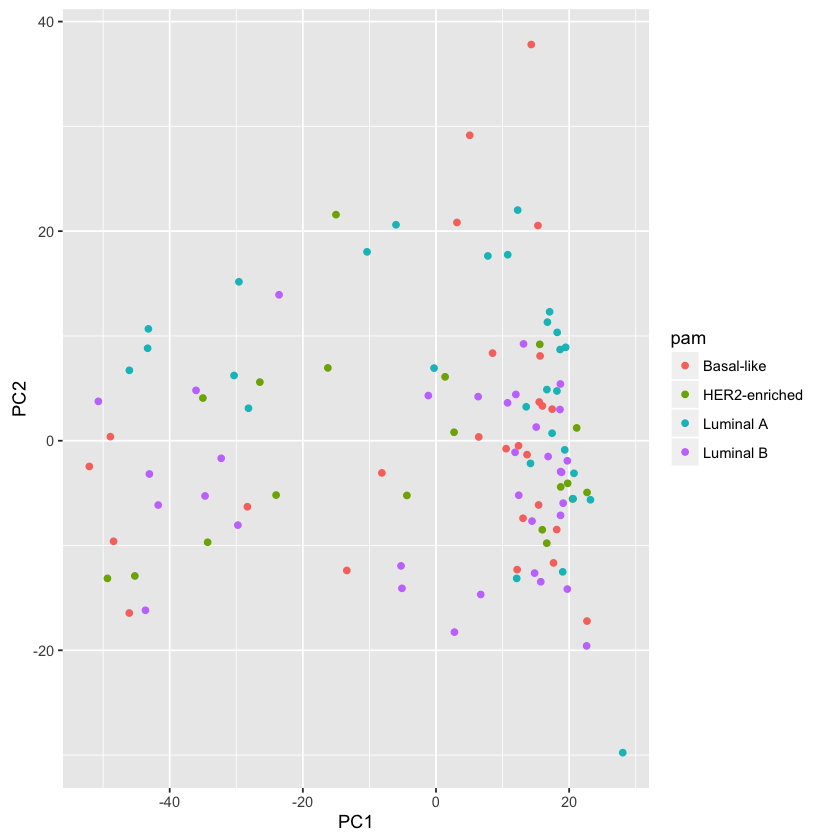

In [189]:
df <- data.frame(p$x[,1:2])
df$pam <- pam.for.sample
ggplot(data = df,aes(x=PC1,y=PC2,colour=pam)) + geom_point()

The colors used here are not the "official" colors of the subtypes, which may offend some purists - we just take the default color scheme of ggplot2. It would be easy enough to fix.

In any case, the PCA (at least components 1 and 2) does not seem to show a clustering according to the predict PAM50 subtypes. Maybe the protein expression is not especially correlated to the mRNA expression? We will address that question a little further down.

First, though, let's try to find out if we can do a reasonable job of classifying the samples into PAM50 subtypes using a subset of the proteins (gene products). For this, we turn to the Boruta feature selection package.

<h2>Can we find a set of features that predicts PAM50 subtypes?</h2>

Here we might need to remind ourselves that the goal is not really to recapitulate the PAM50 subtypes; after all, we already have those from mRNA data. We might want to try to derive a different kind of classification from the proteomics data themselves, for instance by some sort of unsupervised method (e g clustering). However, for now, the PAM50 subtypes are what we will focus on. The Boruta package is a useful wrapper around the random forest algorithm which can be used to find relatively compact sets of features that perform well on a given classification task. See PDF here www.jstatsoft.org/article/view/v036i11/v36i11.pdf for a description of how it works. The package is based on ideas from the likewise interesting paper *Consistent Feature Selection for Pattern
Recognition in Polynomial Time The Journal* by Nilsson et al. in Machine Learning Research (2007), which I recommend if you are interested in feature selection in general.

In [190]:
feat <- Boruta(x = t(itraq.log), y = as.factor(tcga.pam$x))

Boruta classifies each input feature as "Confirmed", "Tentative" or "Rejected". These terms refer to the extent to which Boruta believes that they are part of the "minimal-optimal model", i e a relatively small set of features that will still provide a good classification performance. Here, we will only use the ones that Boruta is sure of, the "Confirmed" ones.

In [191]:
feat.conf <- names(feat$finalDecision[which(feat$finalDecision=="Confirmed")])

This gives a list of about 40 gene products. Introduce a function for doing leave-one-out random forest classification using these.

In [192]:
do.loo <- function(mx, classes){
  loo <- NULL
  for(i in colnames(mx)){
    rf <- randomForest(t(mx[,-which(colnames(mx)==i)]), classes[-which(rownames(classes)==i),])
    loo[[i]] <- as.character(predict(rf, newdata=mx[,which(rownames(classes)==i)]))
  }
  return(table(classes$x, loo))
}

We can run this as follows:

In [193]:
loo <- do.loo(itraq.log[feat.conf,], tcga.pam)

In [194]:
print("Confusion matrix:")
print(loo)
print("Accuracy:")
print(sum(diag(loo))/sum(loo))
print("Majority prediction:")
print(max(table(tcga.pam))/sum(table(tcga.pam)))
print(table(tcga.pam))

[1] "Confusion matrix:"
               loo
                Basal-like HER2-enriched Luminal A Luminal B
  Basal-like            24             1         1         0
  HER2-enriched          0            15         1         3
  Luminal A              1             1        20         7
  Luminal B              0             2         4        28
[1] "Accuracy:"
[1] 0.8055556
[1] "Majority prediction:"
[1] 0.3148148
tcga.pam
   Basal-like HER2-enriched     Luminal A     Luminal B 
           26            19            29            34 


We can see from the confusion matrix that the classification performance is reasonable though far from perfect. The overall accuracy is about 80%, whereas a naïve baseline classification of just guessing the most common class (luminal B) would yield an accuracy of 34/108 = 31.5%. 

Furthermore, we can see that the basal-like subtype is the one that gets predicted most accurately - for 26 predictions of "Basal" on unseen samples, 24 of those (92%) were actually classified as basal. From this confusion matrix, one could calculate the specificity and sensitivity of the different classes.

Above, we did a PCA plot using all the gene products which did not show much structure. Let's repeat it with only the Boruta-selected features:

<comment on the prediction accuracy>
<new PCA plot>

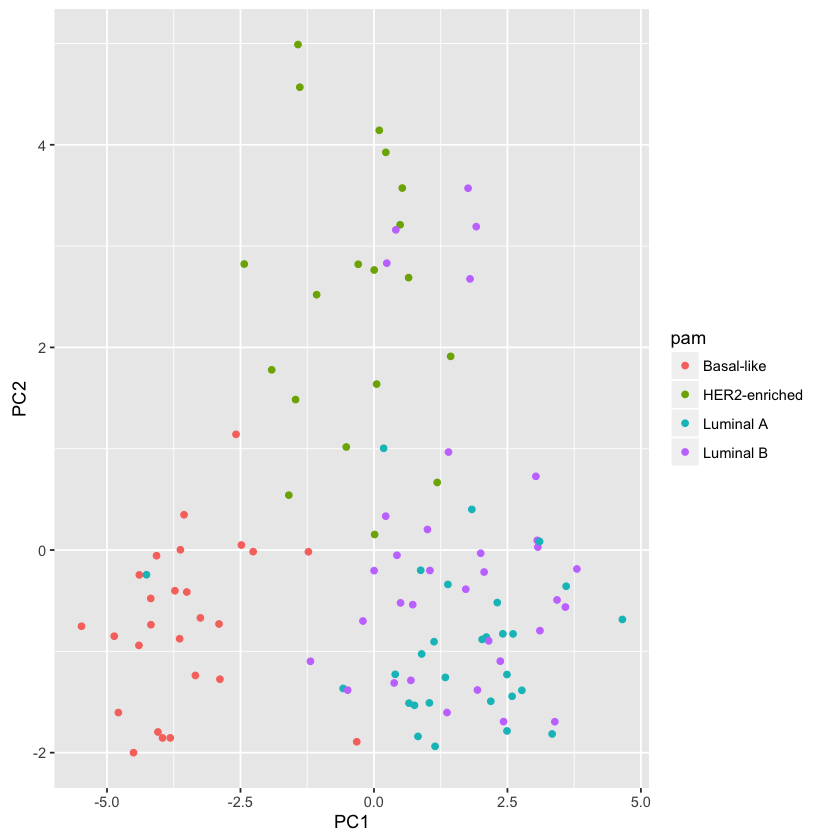

In [195]:
p <- prcomp(t(itraq.log[feat.conf,]))
df <- data.frame(p$x[,1:5])
df$pam <- pam.for.sample
ggplot(data = df,aes(x=PC1,y=PC2,colour=pam)) + geom_point()
#pheatmap(itraq.log[feat.conf,], annotation_col = tcga.pam)

This definitely looks more structured, even though the luminal types still aren't clearly resolved. PC projections to other axis (e g PC2 and PC4) however show a cleared distinction between Luminal A and Luminal B.

If we want to see what the expression distribution per class is for some of these gene products, we could introduce a function like this:

In [196]:
multibox_tcga <- function(gene, mx, pam50, anno=""){
  boxplot(as.numeric(mx[gene, which(pam50=="Basal-like")]), t(mx[gene, which(pam50=="Luminal A")]), t(mx[gene, which(pam50=="Luminal B")]), t(mx[gene, which(pam50=="HER2-enriched")]),names=c("Basal","LumA","LumB","Her2"),main=paste(anno, gene),las=2,col=c("Red","Darkblue","Lightblue","Purple"))
}

For instance, we could look at ERBB2, which is one of the features picked up by Boruta. This is a gene that encodes a protein often known as HER2, which should be enriched in the "HER2-enriched" subtype (obviously).

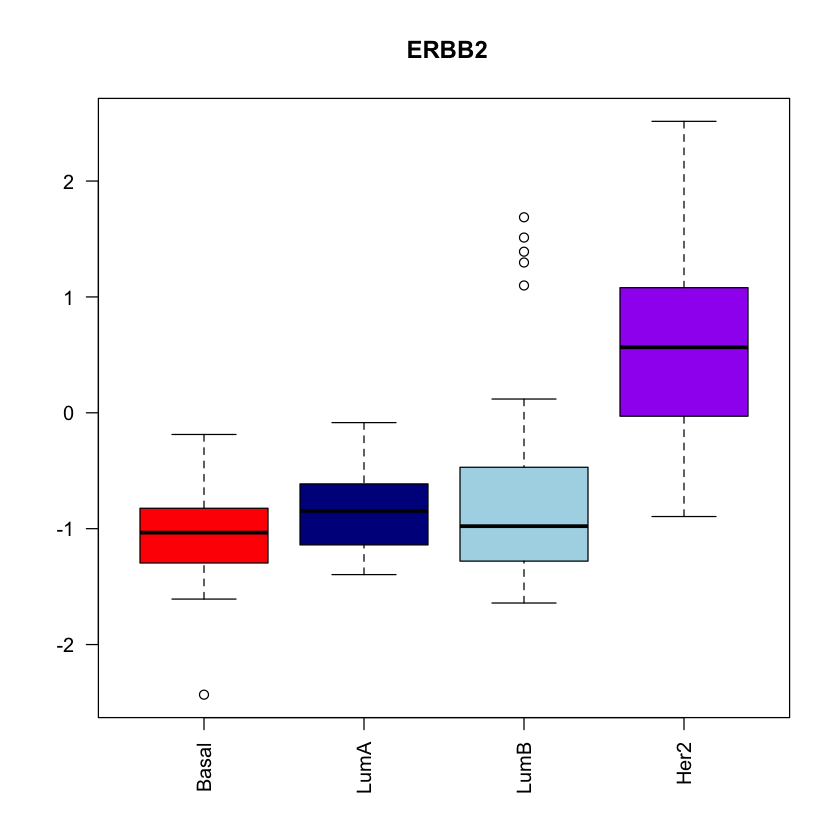

In [197]:
multibox_tcga('ERBB2', itraq.log, tcga.pam)

Indeed, ERBB2 does seem to be enriched in the Her2 subtype. Before we turn to the RNA-seq part, let's just check if any of the predictive features we have found corresponds to druggable protein targets. We start by downloading a list of druggable targets from the Human Protein Atlas.

<h2>Comparing the proteomics data to RNA-seq data</h2>

There are many ways to get RNA-seq data from TCGA, but if you are an R user, one of the most convenient ways is to use the TCGA2STAT package that we imported at the beginning of the notebook. With it, you can specify a disease and a data type (e.g. RNA-seq, microarray, reverse phase protein arrays (RPPA), SNPs). 

In [198]:
rnaseq.bc <- getTCGA(disease="BRCA", data.type="RNASeq2")

RNASeqV2 data will be imported! This may take some time!
20501 genes have been imported!


We could also have asked for clinical information by including the "clinical" option in the getTCGA call, but we are not interested in that right now. The actual RNA-seq expression data (called using RSEM) is in rnaseq.bc$dat:

In [199]:
rna <- rnaseq.bc$dat
rna[1:5, 1:5]

,TCGA-3C-AAAU-01A-11R-A41B-07,TCGA-3C-AALI-01A-11R-A41B-07,TCGA-3C-AALJ-01A-31R-A41B-07,TCGA-3C-AALK-01A-11R-A41B-07,TCGA-4H-AAAK-01A-12R-A41B-07
A1BG,197.0897,237.3844,423.2366,191.0178,268.8809
A1CF,0.0000,0.0000,0.9066,0.0000,0.4255
A2BP1,0.0000,0.0000,0.0000,0.0000,3.8298
A2LD1,102.9634,70.8646,161.2602,62.5072,154.3702
A2ML1,1.3786,4.3502,0.0000,1.6549,3.4043


In order to compare the mRNA and protein-level data, we need to have (1) a consistent set of genes/gene products, (2) a consistent set of samples.

In [200]:
common.gene.ids <- intersect(rownames(rna), rownames(itraq.log))

At this point, we cannot really avoid dealing with the three replicated samples in the mass spectrometry data anymore. Instead of throwing out one of the replicates, I use the following slightly ugly hard-coded snippet to replace the six (3 samples x 2 replicate) columns in question with three columns, each of which represents the means of the replicates for each sample.

In [201]:
dups <- short_id[which(duplicated(short_id))]

mean.AOA12D <- rowMeans(itraq.log[,which(short_id == "AO-A12D")])
mean.C8A131 <- rowMeans(itraq.log[,which(short_id == "C8-A131")])
mean.AOA12B <- rowMeans(itraq.log[,which(short_id == "AO-A12B")])

itraq_ <- itraq.log
colnames(itraq_) <- short_id
itraq_ <- itraq_[,-which(short_id %in% dups)]
tmp <- cbind(itraq_, mean.AOA12D, mean.C8A131, mean.AOA12B)
colnames(tmp)[103:105] <- c("AO-A12D", "C8-A131", "AO-A12B")
dim(tmp)

[1] 6953  105

Now we have to identify the samples that are in both the RNA-seq and the proteomics data.

In [202]:
rna.names <- unlist(lapply(colnames(rna), get_id_from_pam_name))
common.samp <- intersect(rna.names, colnames(tmp))

rna_ <- rna
colnames(rna_) <- rna.names

prt.c <- tmp[common.gene.ids, common.samp]
rna.c <- log2(1 + rna_[common.gene.ids, common.samp])

We put the mRNA data on a log scale (with a pseudocount of 1 to avoid logs of zero) since the protein-level data are on a log scale. We now have protein and mRNA expression matrices of the same size (4808 genes x 105 tumors), representing the same genes/gene products and the same samples.

In [203]:
identical(colnames(prt.c),colnames(rna.c))
identical(rownames(prt.c),rownames(rna.c))
print(c(dim(prt.c),dim(rna.c)))

[1] TRUE

[1] TRUE

[1] 6597  105 6597  105


Now we can look at the distribution of correlations between mRNA and protein for each gene.

In [204]:
genecorrs <- c()
genenames <- c()
for (i in 1:nrow(rna.c)){
  genecorrs <- c(genecorrs, cor(rna.c[i,], prt.c[i,]))
  genenames <- c(genenames, rownames(rna.c)[i])
}

Warning message:
In cor(rna.c[i, ], prt.c[i, ]): the standard deviation is zero

[1] -0.2644779  0.8549557


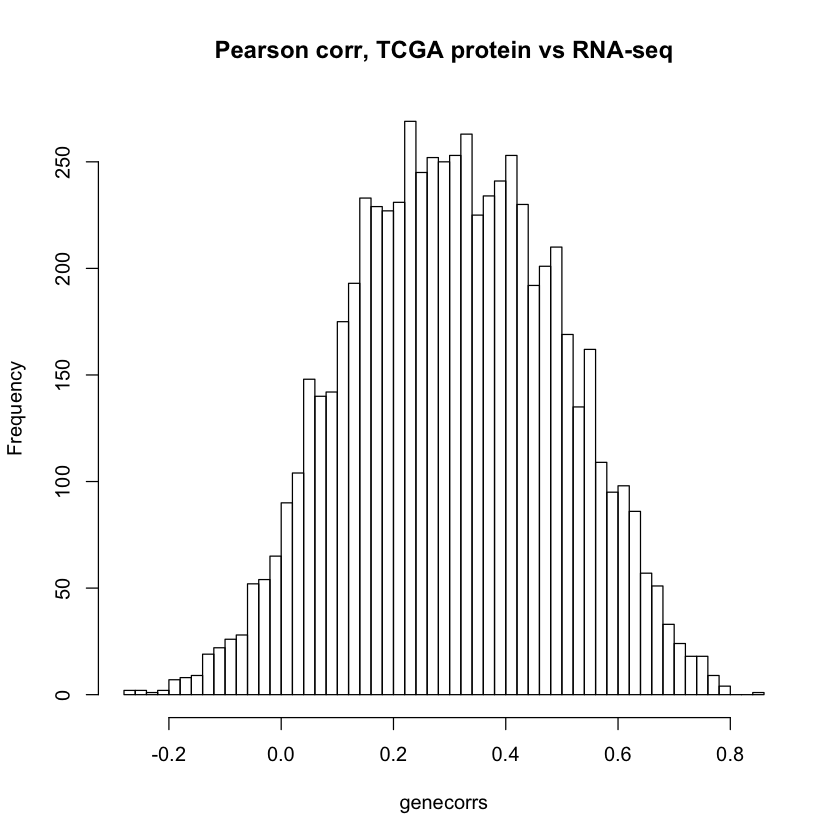

In [205]:
hist(genecorrs, n=50, main="Pearson corr, TCGA protein vs RNA-seq")
print(range(na.omit(genecorrs)))

Another way to visualize it would be a "sorted barplot": 

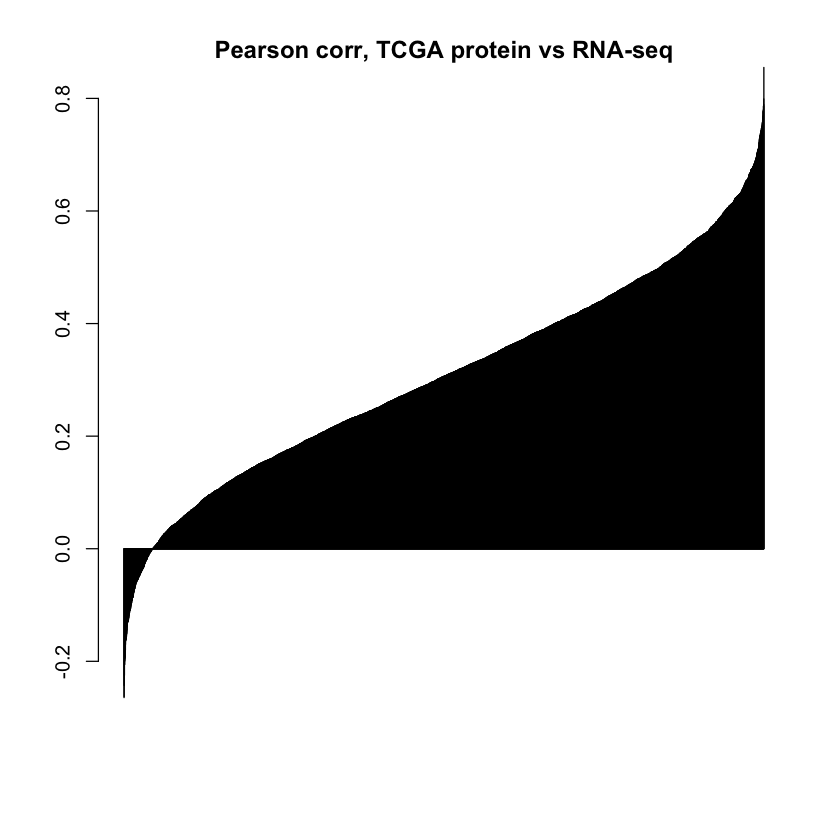

In [206]:
barplot(genecorrs[order(genecorrs)], main="Pearson corr, TCGA protein vs RNA-seq", ylim=c(-0.3,0.8))

The correlations between mRNA and protein range from about -0.25 to 0.85, with mean, median and mode somewhere around 0.30. Not great overall, in other words.

What does it look like if we restrict the comparison to the genes in the PAM50 signature?

In [207]:
pam50.genes <- c("ACTR3B", "ANLN", "BAG1", "BCL2", "BIRC5", "BLVRA", "CCNB1", 
                 "CCNE1", "CDC20", "CDC6", "CDH3", "CENPF", "CEP55", "CXXC5", 
                 "EGFR", "ERBB2", "ESR1", "EXO1", "FGFR4", "FOXA1", "FOXC1", 
                 "GPR160", "GRB7", "KIF2C", "KRT14", "KRT17", "KRT5", "MAPT", 
                 "MDM2", "MELK", "MIA", "MKI67", "MLPH", "MMP11", "MYBL2", 
                 "MYC", "NAT1", "NDC80", "NUF2", "ORC6L", "PGR", "PHGDH",
                 "PTTG1", "RRM2", "SFRP1", "SLC39A6", "TMEM45B", "TYMS", "UBE2C", "UBE2T")

In [208]:
pam.in.our.data <- intersect(pam50.genes, rownames(rna.c))
pamcorrs <- c()
for (i in 1:nrow(rna.c[pam.in.our.data,])){
  pamcorrs <- c(pamcorrs, cor(rna.c[i,], prt.c[i,]))
}

Somewhat disappointingly, only 26 PAM50 genes were present in both the RNA-seq and the proteomics data set. Some of them may have disappeared when we removed NA-containing gene products from the proteomics matrix. Oh well, let's look at their correlations anyway. It doesn't make much sense to use a histogram for only 26 genes, so we use a barplot.

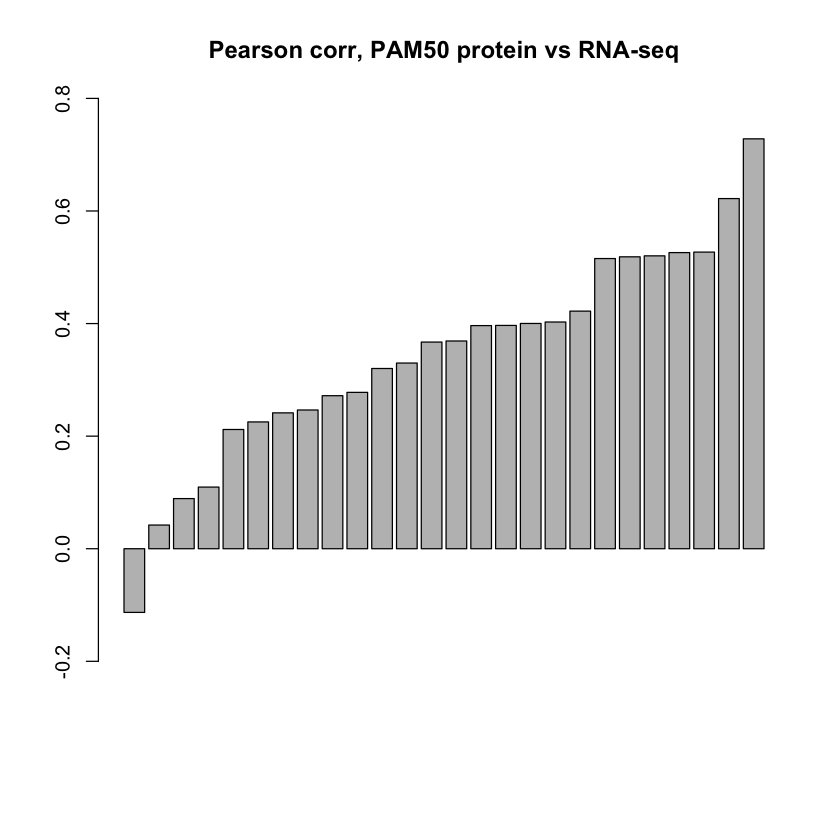

In [210]:
barplot(pamcorrs[order(pamcorrs)], main="Pearson corr, PAM50 protein vs RNA-seq",ylim=c(-0.3,0.8))